<a href="https://colab.research.google.com/github/NeuroTechBSB/EEG-Foundation-Challenge-2025/blob/main/neurips_eeg_challenge_basic_eda_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NeurotechX BSB - NeurIPS EEG Challenge

This notebook is a first exploratory data analysis (EDA) of the [HBN-EEG: Healthy Brain Network EEG Datasets](https://neuromechanist.github.io/data/hbn/).

Given the size of each release, this notebook only uses Release 6 (~90gb). Since colab has limits to available memory, we opted to only load one subject at a time for this initial phase.

    Release 6
    S3 URI: s3://fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6
    Total subjects: 134


Made by the members of the NeurotechX student chapter NeurotechXBSB.

Created by Gabriel L. Jacinto on June 10th 2025.

## Carregando os dados

Para acesso completo, usaremos o AWS CLI e o link correspondente fornecido no site HBN-EEG: Healthy Brain Network EEG Datasets.

Usaremos as seguintes bibliotecas Python:

- mne: para carregamento, visualização, filtragem e segmentação (epoching) de EEG
- pandas: para lidar com metadados em arquivos .tsv
- matplotlib / seaborn: para visualizações

In [ ]:
!pip install s3fs
!pip install mne
!pip install pandas matplotlib seaborn ipympl ipywidgets PyQt5 PySide2--quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 53.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.

In [ ]:
import s3fs
import mne
import pandas as pd
import json
import pprint
import ipywidgets as widgets
from IPython.display import display, clear_output

In [ ]:
# acessando via link público
fs = s3fs.S3FileSystem(anon=True)

# Vendo a estrutura da pasta inicialmente
folders = fs.ls('fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6')
print("Folders:")
pprint.pprint(folders)


Folders:
['fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/README',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/code',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/dataset_description.json',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/participants.json',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/participants.tsv',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/sub-NDARAB055BPR',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/sub-NDARAB348EWR',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/sub-NDARAB458VK9',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/sub-NDARAB708LM5',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/sub-NDARAB756JDJ',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/sub-NDARAD224CRB',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/sub-NDARAE301XTM',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/sub-NDARAE877NER',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6/sub-NDARAN262WK6',
 'fcp-indi/data/Projects/HBN/BIDS_EEG/

Aparentemente temos muita coisa aí. Segundo o próprio site a estrutura é a seguinte:

    cmi_bids_R6/
    ├── code/                      ← Scripts de apoio
    ├── dataset_description.json   ← Metainformação BIDS do dataset
    ├── participants.tsv           ← Tabela com dados dos participantes
    ├── participants.json          ← Descrição dos campos da tabela acima
    ├── README                     ← Explicação geral do dataset
    ├── task-*_eeg.json            ← Metadados de cada tarefa (filmes, etc.)
    ├── task-*_events.json         ← Eventos marcados nas tarefas
    ├── sub-NDARxxxxxxx/           ← Dados individuais de cada participante
    │   ├── eeg/
    │   └── ...

Para mais informações sobre essa organização veja sobre o [BIDS](https://bids.neuroimaging.io/).

Dropdown(description='Sujeito:', layout=Layout(width='50%'), options=('sub-NDARAB055BPR', 'sub-NDARAB348EWR', …

Dropdown(description='Tarefa:', layout=Layout(width='70%'), options=('DespicableMe', 'DiaryOfAWimpyKid', 'Funw…

Button(description='Carregar EEG', style=ButtonStyle())

<ipython-input-9-2896016531>:90: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(local_set, preload=True)



✅ Carregado: sub-NDARAB055BPR - DespicableMe

<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 129 EEG
 custom_ref_applied: False
 dig: 132 items (3 Cardinal, 129 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>


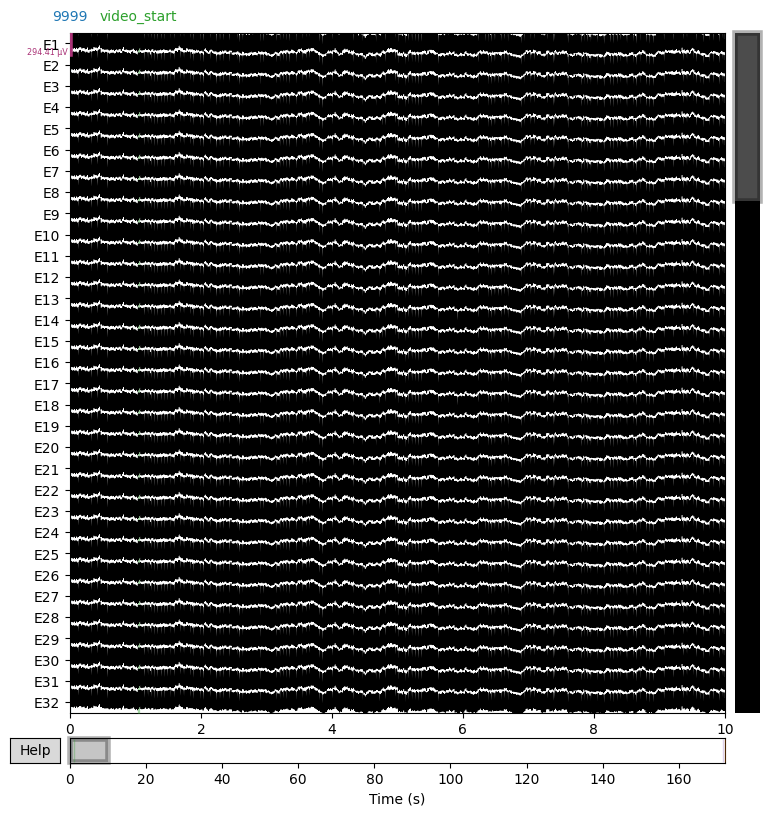

In [ ]:
#@title Código interativo para navegar os dados dos participantes

#tentando alterar o backend pq o colab é fresco
%matplotlib inline
# Conecte-se ao bucket S3 (anonimamente)
fs = s3fs.S3FileSystem(anon=True)
root_path = 'fcp-indi/data/Projects/HBN/BIDS_EEG/cmi_bids_R6'

# Lista pastas dos sujeitos
all_entries = fs.ls(root_path, detail=True)
subject_folders = sorted(list({e['Key'].split('/')[-1] for e in all_entries if 'sub-' in e['Key']}))

# Cria dropdown para escolher participante
subject_dropdown = widgets.Dropdown(
    options=subject_folders,
    description='Sujeito:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Dropdown para tarefas (será preenchido após escolha do sujeito)
task_dropdown = widgets.Dropdown(
    options=[],
    description='Tarefa:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

# Botão para carregar dados
load_button = widgets.Button(description='Carregar EEG')

# Função para atualizar o dropdown de tarefas
def update_tasks(subject_id):
    eeg_folder = f"{root_path}/{subject_id}/eeg"
    try:
        subject_files = fs.ls(eeg_folder)
        event_files = [f for f in subject_files if f.endswith('_events.tsv')]
        tasks = sorted([
            f.split('/')[-1]
             .replace(f"{subject_id}_task-", "")
             .replace("_events.tsv", "")
             for f in event_files
        ])
        task_dropdown.options = tasks
    except Exception as e:
        print(f"Erro ao acessar arquivos para {subject_id}: {e}")
        task_dropdown.options = []

def on_task_change(change):
    subject_id = subject_dropdown.value
    task_name = change['new']

# Função chamada ao mudar participante
def on_subject_change(change):
    subject_id = change['new']
    subject_path = f"{root_path}/{subject_id}/eeg"
    try:
        eeg_files = fs.ls(subject_path)
        task_options = sorted([
            f.split('/')[-1].replace('_eeg.set', '')
            for f in eeg_files if f.endswith('.set')
        ])
        task_dropdown.options = task_options
    except Exception as e:
        task_dropdown.options = []
        print(f"Erro ao listar tarefas: {e}")

subject_dropdown.observe(on_subject_change, names='value')
task_dropdown.observe(on_task_change, names='value')

# Função ao clicar em "Carregar EEG"
def on_load_clicked(b):
    clear_output(wait=True)
    display(subject_dropdown, task_dropdown, load_button)

    subject_id = subject_dropdown.value
    task_name = task_dropdown.value
    subject_path = f"{root_path}/{subject_id}/eeg"

    eeg_file = f"{subject_path}/{subject_id}_task-{task_name}_eeg.set"
    json_file = eeg_file.replace('_eeg.set', '_eeg.json')
    tsv_file = eeg_file.replace('_eeg.set', '_events.tsv')

    local_set = f"/tmp/{subject_id}_task-{task_name}_eeg.set"
    local_json = f"/tmp/{subject_id}_task-{task_name}_eeg.json"
    local_tsv = f"/tmp/{subject_id}_task-{task_name}_events.tsv"

    try:
        fs.get(eeg_file, local_set)
        raw = mne.io.read_raw_eeglab(local_set, preload=True)
        print(f"\n✅ Carregado: {subject_id} - {task_name}\n")
        print(raw.info)
        raw.plot(n_channels=32, scalings='auto', title=f"{task_name} EEG", show_scrollbars=True, block=True)
    except Exception as e:
        print("Erro ao carregar .set:", e, eeg_file, local_set)
        return

    # # Carrega e exibe eventos
    # try:
    #     fs.get(tsv_file, local_tsv)
    #     df = pd.read_csv(local_tsv, sep='\t')
    #     print("\n📊 Eventos:")
    #     display(df.head())
    # except FileNotFoundError:
    #     print("⚠️ Nenhum arquivo de eventos (.tsv) encontrado.")

    # # Carrega e exibe metadata
    # try:
    #     fs.get(json_file, local_json)
    #     with open(local_json, 'r') as f:
    #         metadata = json.load(f)
    #     print("\n📄 Metadata:")
    #     pprint.pprint(metadata)
    # except FileNotFoundError:
        # print("⚠️ Nenhum arquivo JSON de metadata encontrado.")

load_button.on_click(on_load_clicked)

# Exibe widgets
display(subject_dropdown, task_dropdown, load_button)

# Inicializa com o primeiro participante
update_tasks(subject_dropdown.value)

# Notas (pessoais da Bruna e da reunião do dia 27/06)

[Details about the EEG Challenge](https://https://eeg2025.github.io/)

Dataset: Healthy Brain Network EEG Datasets (HBN-EEG)

Details about the dataset (condensed from https://neuromechanist.github.io/data/hbn/):
- Collection of high-resolution EEG data from over 3,000 participants aged 5-21 years;
- Currently, HBN-EEG includes 11 dataset releases in the Brain Imaging Data Structure (BIDS) format, containing EEG and behavioral data from different subjects performing the same tasks;
- These datasets also contain rich task-event annotations using Hierarchical Event Descriptors (HED). Future enhancements will include more data layers such as eye-tracking and personalized EEG features.

About the tasks:
- Passive Tasks:
   - Resting State (RS): Eyes open/closed conditions with fixation cross
   - Surround Suppression (SuS): Four flashing peripheral disks with contrasting background
   - Movie Watching (MW): Four short films with different themes
- Active Tasks
   - Contrast Change Detection (CCD): Identifying dominant contrast in co-centric flickering grated disks
   - Sequence Learning (SL): Memorizing and reproducing sequences of flashed circles
   - Symbol Search (SyS): Computerized version of WISC-IV subtest



To access datasets: https://neuromechanist.github.io/data/hbn/
(**!! Attention, there are different datasets in this link, one is the HBN-EEG complete data (NEMAR version and Amazon S3) and the others are smaller versions of the full datasets, containing only the data for the 20 participants who performed all tasks (Google Drive and Zip) !!**)

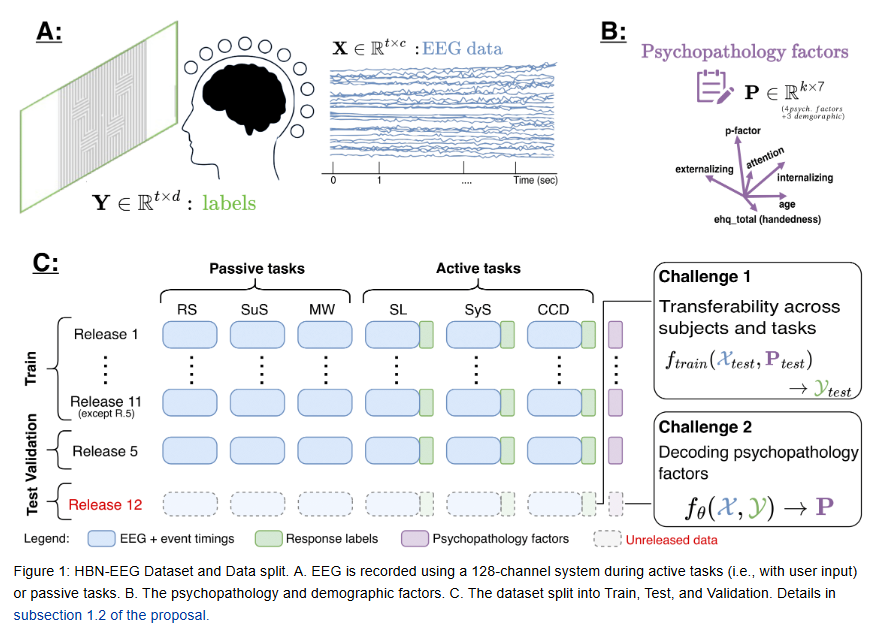

[Subsection 1.2 of the proposal.](https://https://eeg2025.github.io/assets/files/proposal.pdf)

In [ ]:
'''
Info | 8 non-empty values                               ← Informacoes sobre a variavel em si (que tem 8 valores nao vazios, i.e. 8 non-[] )
 bads: []                                               ← Indicacao de qualidade do dataset, provavelmente referente a bad channels (valor nao-vazio, portanto a qualidade esta boa)
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, ... E129     ← Nomenclatura dos canais do EEG (o canal E129 nao aparece na variavel, mas coloquei para deixar mais claro)
 chs: 129 EEG                                           ← Quantidade de canais e tipo de sinal EEG (EEG de 129 canais = alta-resolucao)
 custom_ref_applied: False                              ← Indica se o data set sofreu alteracao da referencia eletrica original da coleta (nesse caso, ainda nao)
 dig: 132 items (3 Cardinal, 129 EEG)                   ←
 highpass: 0.0 Hz                                       ← Indica se houve aplicacao de filtro high-pass no sinal (sinal bruto, nao houve filtragem high-pass)
 lowpass: 250.0 Hz                                      ← Indica se houve aplicacao de filtro low-pass no sinal (sinal bruto foi filtrado com low-pass de 250Hz)
 meas_date: unspecified                                 ←
 nchan: 129                                             ← Quantidade de canais
 projs: []                                              ←
 sfreq: 500.0 Hz                                        ← Frequencia de amostragem do sinal (sinal bruto = freq. de amostragem usada na coleta)

Processing and creating model: https://braindecode.org/stable/auto_examples/model_building/plot_bcic_iv_2a_moabb_trial.html
(This tutorial shows you how to train and test deep learning models with Braindecode in a classical EEG setting: you have trials of data with labels (e.g., Right Hand, Left Hand, etc.))

Notas reunião EEG Challenge 27/06:
- São as mesmas pessoas que realizam as mesmas tarefas longo da vida (os releases foram feitos ao longo da vidas dessas pessoas)
- Vamos processar os dados cada um fazendo uma parte e depois juntamos tudo para fazer o desafio
- Vamos usar as librarias recomendadas mesmo (ate porque parecem mais faceis de usar do que o MNE)
- Vamos focar por agora na primeira parte do desafio (classificação de active tasks baseado na classificação de passive tasks, considerando os mesmos sujeitos ao longo do tempo, intraparticipante). O segundo desafio parece ser mais voltado para classificações de grupo (interparticipantes).